In [1]:
from u_cmab import Fourier
from u_cmab import Static_UM
from u_cmab import plot_results
import simulation_code

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

In [24]:
window = 150

static_dataset_size = 5000
total_experiment_count = 30000
drift_moments = np.array([10000, 15000, 20000, 25000])

run_count = 10 ** 2

In [25]:
line_args=[{"color": "deepskyblue", "linewidth": 2, "zorder": 103, "label": "U-CMAB"}, {"color": "crimson", "linewidth": 2, "zorder": 102, "label": "Random Forest"}]
band_args=[{"color": "deepskyblue", "alpha": .25, "linewidth":0, "zorder": 101}, {"color": "crimson", "alpha": .1, "linewidth":0, "zorder": 100}]
all_lines_args=[{"color": "deepskyblue", "alpha": .1, "linewidth": .5}, {"color": "crimson", "alpha": .1, "linewidth": .5}]
std_args=[{"color": "deepskyblue", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]}, {"color": "crimson", "linestyle": "--", "linewidth": 2, "dashes": [10, 10]}]
stop_RP_args={"color": "tab:gray", "linewidth":2, "linestyle": "--", "dashes": [5,5], "alpha": .8}
stop_RP_text_args={"y": .95, "color": "tab:gray", "size": 19, "fontstyle": "italic"}
drift_line_args={"linestyle": ":", "color": "tab:green", "alpha": 1, "linewidth": 3}

In [26]:
fourier_ids = np.empty([run_count, total_experiment_count])
static_ids = np.empty([run_count, total_experiment_count])
static_params = np.empty([run_count, 2])

for i in range(run_count):
    tau= (.25 - .15) * np.random.ranf() + .15
    std = (.4 - .2) * np.random.ranf() + .2
    ply_q = np.random.randint(6,10)
    K=np.random.normal(1,.5, ply_q+1)
    drift_rate=2.5# (3.0 - 2.0) * np.random.ranf() + 2.0
    
        #  the order of the Fourier approx. (O) is best chosen in 
        #  function of D as O and D affect the amount of frequency 
        #  vectors exponentially, causing a curse of dimensionality
        #  [Konindaris et al., 2011].
    D = np.random.randint(2,5)   
    O = 8-D 

    sim = simulation_code.Simulation(
        D=2, std=std, drift_moments=drift_moments, drift_rate=drift_rate, sudden_drift=True,
        base_functions=np.array([
            simulation_code.Sine_Base(f=4),#np.random.randint(6,10)), 
            simulation_code.Sine_Base(f=5)#np.random.randint(6,10))
        ]))
    
    fourier = Fourier(sim, order=5)
    fourier_id, fourier_dm = fourier.run(
        epsilon=.1, 
        alpha=.005, 
        tau=tau, window=window, 
        lifetime=total_experiment_count)
    print("--Fourier {} Completed--".format(i+1))
    
    static = Static_UM(RP_run_history=fourier.RP_run_history)
    up, static_id = static.run(
        static_dataset_size=static_dataset_size, 
        total_experiment_count=total_experiment_count, 
        tau=tau, window=window)
    
    fourier_ids[i] = fourier_id
    static_ids[i] = static_id
    static_params[i] = list(up.rand_search_.best_params_.values())

--Fourier 1 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 2 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 3 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 4 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 5 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 6 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 131 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 7 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 8 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 9 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 10 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 11 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 12 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 13 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 14 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 15 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 16 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 17 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 18 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 19 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 20 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 21 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 22 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   20.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 23 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 24 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 25 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 26 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 27 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 28 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 29 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 30 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 128 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 31 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 32 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 33 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   16.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   21.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 34 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 35 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 36 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 37 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 38 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 39 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 40 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 41 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   16.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   20.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 42 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 43 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 44 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 45 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 46 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 47 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 48 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 49 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 50 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 51 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 52 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 53 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 54 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 55 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 56 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 57 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 58 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 59 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   20.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 60 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 61 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 62 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 63 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 64 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 65 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 66 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 67 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 68 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 69 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 70 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 71 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 72 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 73 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 74 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   16.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 75 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 76 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 77 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 78 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 79 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 80 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 81 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 82 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 83 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 84 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 85 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 86 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 87 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 88 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 89 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 90 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 91 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 92 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 93 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 94 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 95 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 96 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 97 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 98 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 99 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 100 Completed--
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
avg_ids = [np.mean(fourier_ids, axis=0), np.mean(static_ids, axis=0)]
stds = [np.std(fourier_ids, axis=0), np.std(static_ids, axis=0)]

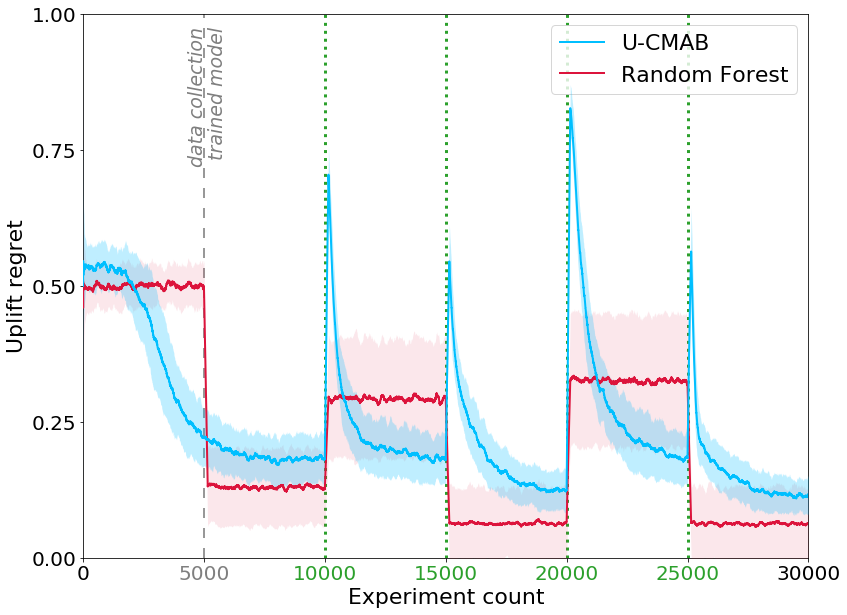

In [28]:
fig, ax = plot_results(avg_ids, stds, drift_moments, 
                 line_args=line_args, band_args=band_args, all_lines_args=all_lines_args, std_args=std_args,
                stop_RP=static_dataset_size, stop_RP_args=stop_RP_args, stop_RP_text_args=stop_RP_text_args, drift_line_args=drift_line_args)

In [30]:
ax.figure.savefig('sudden.pdf', bbox_inches='tight', pad_inches=0)

In [77]:
static_dataset_size_gd = 5000
total_experiment_count_gd = 20000
drift_over_time_gd = 20000
run_count_gd = 10 ** 2

In [78]:
fourier_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
static_ids_gd = np.empty([run_count_gd, total_experiment_count_gd])
static_params_gd = np.empty([run_count_gd, 2])

for i in range(run_count_gd):
    tau= (.25 - .15) * np.random.ranf() + .15
    std = (.4 - .2) * np.random.ranf() + .2
    ply_q = np.random.randint(6,10)
    K=np.random.normal(1,.5, ply_q+1)
    drift_rate=(2.7 - 2.3) * np.random.ranf() + 2.3
    
        #  the order of the Fourier approx. (O) is best chosen in 
        #  function of D as O and D affect the amount of frequency 
        #  vectors exponentially, causing a curse of dimensionality
        #  [Konindaris et al., 2011].
    D = np.random.randint(2,4)   
    O = 7-D 

    sim = simulation_code.Simulation(
        D=D, std=std, drift_over_time=drift_over_time_gd, drift_rate=drift_rate, sudden_drift=False,
        base_functions=np.array([
            simulation_code.Sine_Base(f=np.random.randint(3,6)), 
            simulation_code.Sine_Base(f=np.random.randint(4,7))
        ]))
    
    fourier = Fourier(sim, order=O)
    fourier_id, fourier_dm = fourier.run(
        epsilon=.1, 
        alpha= (O-1)/1000,
        tau=tau, window=window, 
        lifetime=total_experiment_count_gd)
    print("--Fourier {} Completed--".format(i+1))
    print(fourier_dm)
    
    static = Static_UM(RP_run_history=fourier.RP_run_history)
    up, static_id = static.run(
        static_dataset_size=static_dataset_size_gd, 
        total_experiment_count=total_experiment_count_gd, 
        tau=tau, window=window)
    
    fourier_ids_gd[i] = fourier_id
    static_ids_gd[i] = static_id
    static_params_gd[i] = list(up.rand_search_.best_params_.values())

--Fourier 1 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   16.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   19.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 2 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   16.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 3 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 4 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   17.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   22.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 5 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 6 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 7 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 8 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 128 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 9 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 10 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 11 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 12 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 13 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 14 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 15 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 16 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 17 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 18 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 19 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 20 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 21 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 22 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 23 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 24 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 25 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    6.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 26 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 27 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 28 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 29 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 30 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 31 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 32 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 33 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 34 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 35 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 36 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 37 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 38 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 39 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   18.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 40 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 41 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 42 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 43 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 44 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   13.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 45 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 46 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 47 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 48 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 49 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 50 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 51 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 52 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 53 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 54 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   23.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   32.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 55 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 56 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 57 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 58 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 59 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 60 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 61 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 62 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 63 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 64 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 65 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 66 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.8s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 67 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 68 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   14.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 69 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 70 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 71 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   19.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   26.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 72 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 73 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 74 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 75 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 76 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 77 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 78 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 79 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 80 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 81 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 82 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 83 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 84 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 85 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 86 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 87 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 88 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 89 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.3s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 90 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.4s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 91 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.0s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 92 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   11.5s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 93 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 94 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.6s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 95 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 96 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.7s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 97 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.1s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 98 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 99 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    8.9s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--Fourier 100 Completed--
[]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   10.2s finished
/Users/jeroen/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [79]:
avg_ids_gd = [np.mean(fourier_ids_gd, axis=0), np.mean(static_ids_gd, axis=0)]
stds_gd = [np.std(fourier_ids_gd, axis=0), np.std(static_ids_gd, axis=0)]

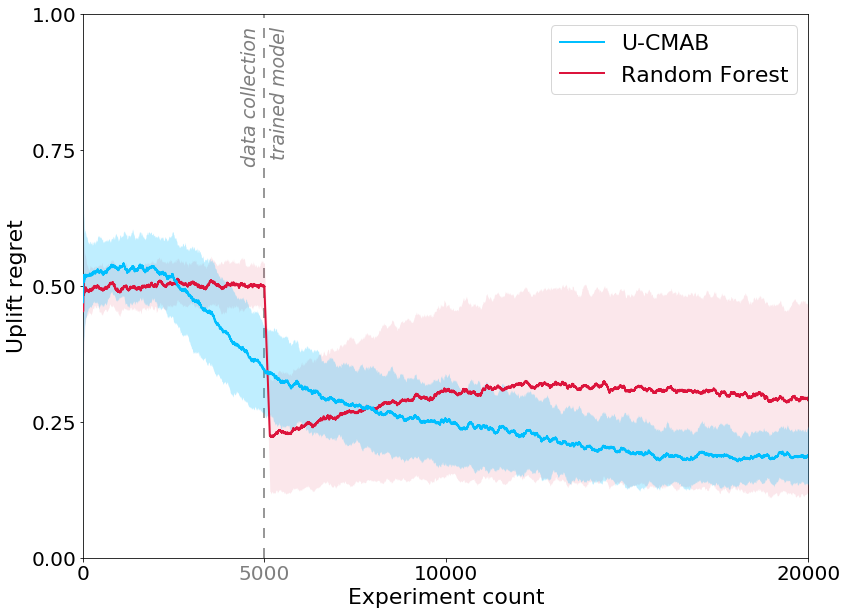

In [80]:
fig_gd, ax_gd = plot_results(avg_ids_gd, stds_gd, np.array([]), 
                 line_args=line_args, band_args=band_args, all_lines_args=all_lines_args, std_args=std_args,
                stop_RP=static_dataset_size, stop_RP_args=stop_RP_args, stop_RP_text_args=stop_RP_text_args, drift_line_args=drift_line_args)